# Lab 3
## Motion Capture Clustering

### Team members: Luay Dajani, Dana Geislinger, Chris Morgan, Caroll Rodriguez
##### Github - https://github.com/cdmorgan103/7331DataMiningNoShow

MSDS 7331, 12/02/2018

### Business Understanding 1
#### 10pts
Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific
dataset and the stakeholders needs?


https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures#

A Vicon motion capture camera system was used to record 12 users performing 5 hand postures with markers attached to a left-handed glove. 

A rigid pattern of markers on the back of the glove was used to establish a local coordinate system for the hand, and 11 other markers were attached to the thumb and fingers of the glove. 3 markers were attached to the thumb with one above the thumbnail and the other two on the knuckles. 2 markers were attached to each finger with one above the fingernail and the other on the joint between the proximal and middle phalanx. 

The 11 markers not part of the rigid pattern were unlabeled; their positions were not explicitly tracked. Consequently, there is no a priori correspondence between the markers of two given records. In addition, due to the resolution of the capture volume and self-occlusion due to the orientation and configuration of the hand and fingers, many records have missing markers. Extraneous markers were also possible due to artifacts in the Vicon software's marker reconstruction/recording process and other objects in the capture volume. As a result, the number of visible markers in a record varied considerably. 

The data presented here is already partially preprocessed. First, all markers were transformed to the local coordinate system of the record containing them. Second, each transformed marker with a norm greater than 200 millimeters was pruned. Finally, any record that contained fewer than 3 markers was removed. The processed data has at most 12 markers per record and at least 3. For more information, see 'Attribute Information'. 

Due to the manner in which data was captured, it is likely that for a given record and user there exists a near duplicate record originating from the same user. We recommend therefore to evaluate classification algorithms on a leave-one-user-out basis wherein each user is iteratively left out from training and used as a test set. One then tests the generalization of the algorithm to new users. A 'User' attribute is provided to accomodate this strategy. 

This dataset may be used for a variety of tasks, the most obvious of which is posture recognition via classification. One may also attempt user identification. Alternatively, one may perform clustering (constrained or unconstrained) to discover marker distributions either as an attempt to predict marker identities or obtain statistical descriptions/visualizations of the postures. 

##### Attribute Information:

Data is provided as a CSV file. A header provides the name of each attribute. An initial dummy record composed entirely of 0s should be ignored. A question mark '?' is used to indicate a missing value. A record corresponds to a single instant or frame as recorded by the camera system. 

'Class' - Integer. The class ID of the given record. Ranges from 1 to 5 with 1=Fist(with thumb out), 2=Stop(hand flat), 3=Point1(point with pointer finger), 4=Point2(point with pointer and middle fingers), 5=Grab(fingers curled as if to grab). 
'User' - Integer. The ID of the user that contributed the record. No meaning other than as an identifier. 
'Xi' - Real. The x-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11. 
'Yi' - Real. The y-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11. 
'Zi' - Real. The z-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11. 

Each record is a set. The i-th marker of a given record does not necessarily correspond to the i-th marker of a different record. One may randomly permute the visible (i.e. not missing) markers of a given record without changing the set that the record represents. For the sake of convenience, all visible markers of a given record are given a lower index than any missing marker. A class is not guaranteed to have even a single record with all markers visible. 


### Data Understanding 1
#### 10pts
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [1]:
# Import required modules
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from matplotlib import style
from pprint import pprint
from IPython.display import display

# Load the data into variable 'df'
df = pd.read_csv('https://raw.githubusercontent.com/cdmorgan103/7331DataMiningNoShow/master/LAB3/Postures.csv')

# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78096 entries, 0 to 78095
Data columns (total 38 columns):
Class    78096 non-null int64
User     78096 non-null int64
X0       78096 non-null float64
Y0       78096 non-null float64
Z0       78096 non-null float64
X1       78096 non-null float64
Y1       78096 non-null float64
Z1       78096 non-null float64
X2       78096 non-null float64
Y2       78096 non-null float64
Z2       78096 non-null float64
X3       78096 non-null object
Y3       78096 non-null object
Z3       78096 non-null object
X4       78096 non-null object
Y4       78096 non-null object
Z4       78096 non-null object
X5       78096 non-null object
Y5       78096 non-null object
Z5       78096 non-null object
X6       78096 non-null object
Y6       78096 non-null object
Z6       78096 non-null object
X7       78096 non-null object
Y7       78096 non-null object
Z7       78096 non-null object
X8       78096 non-null object
Y8       78096 non-null object
Z8       78096 n

In [2]:
# we will remove class 0 
df = df[df.Class !=0 ]

#change ? to none to improve data format
df=df.replace({'?': 'NaN'})

#coerces into numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [3]:
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78095 entries, 1 to 78095
Data columns (total 38 columns):
Class    78095 non-null int64
User     78095 non-null int64
X0       78095 non-null float64
Y0       78095 non-null float64
Z0       78095 non-null float64
X1       78095 non-null float64
Y1       78095 non-null float64
Z1       78095 non-null float64
X2       78095 non-null float64
Y2       78095 non-null float64
Z2       78095 non-null float64
X3       77405 non-null float64
Y3       77405 non-null float64
Z3       77405 non-null float64
X4       74975 non-null float64
Y4       74975 non-null float64
Z4       74975 non-null float64
X5       65072 non-null float64
Y5       65072 non-null float64
Z5       65072 non-null float64
X6       52247 non-null float64
Y6       52247 non-null float64
Z6       52247 non-null float64
X7       38943 non-null float64
Y7       38943 non-null float64
Z7       38943 non-null float64
X8       30563 non-null float64
Y8       30563 non-null float64

Only 31 data points appear for the 11th axis and are for one user. We will delete this as a feature as it does not provide any value.

In [5]:
del df['X11']
del df['Y11']
del df['Z11']

### Data Understanding 2
#### 10pts
Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

In [20]:
import pandas as pd
# Print descriptive info for the unique values for each predictor

#1=Fist(with thumb out), 
#2=Stop(hand flat), 
#3=Point1(point with pointer finger), 
#4=Point2(point with pointer and middle fingers), 
#5=Grab(fingers curled as if to grab). 

print('Class:', list(df.Class.unique()))
print('User:', list(df.User.unique()))
#df_User = df.groupby(['User','Class'])['Class'].count() 
df_Class = df.groupby(['Class', 'User'])['User'].count()

df_Class['total'] = sum(df_Class) #df_User 

df_Class

Class: [1, 2, 3, 4, 5]
User: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


Class  User
1      0        1872
       1        1307
       2        1198
       4          29
       5         820
       6         738
       7          84
       8        1097
       9         653
       10       2397
       11       1604
       12        712
       13       2107
       14       1647
2      0        1501
       1         796
       2         808
       4          71
       5        1143
       6         962
       7         124
       8        1392
       9         918
       10       1481
       11       1380
       12        941
       13       1671
       14       1790
3      0        1851
       1         968
               ...  
       12       1087
       13       1672
       14       2020
4      0        1781
       1         561
       2         677
       4         148
       5        1033
       6         744
       7         150
       8        1160
       9         832
       10       1894
       11       1881
       12       1212
       13       1771
 

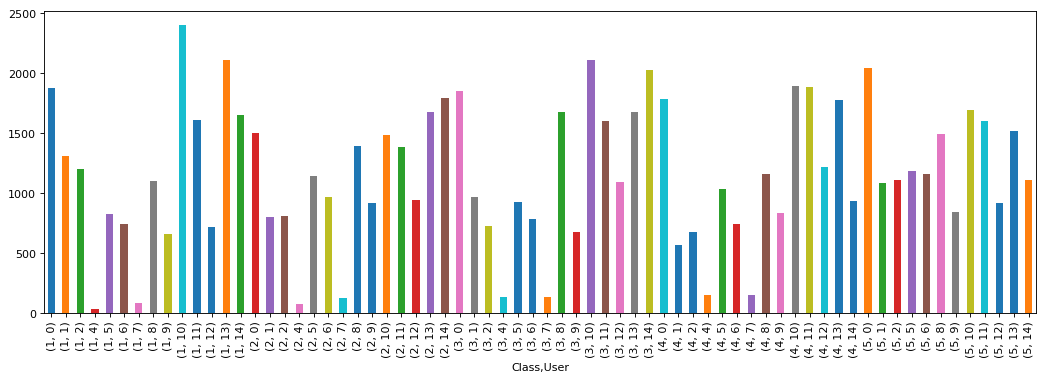

In [7]:
#plot and format bar chart
plt.figure(figsize=(16,5), dpi=80)
_ = df_Class.plot(kind='bar')
#plt.barh(df_neighborhood, width=0.4, height=0.4, align='center', alpha=0.4)

### need help with total for user count to get percentage below

In [8]:
User_byClass = df.groupby(['Class','User']).agg({'User':'nunique','User':'count'})
print("Total Users per Class ")
#agerange_by_gender.columns

total = sum(User_byClass.count())

User_byClass['Percentage'] = User_byClass / total 
User_byClass

Total Users per Class 


User  Percentage
Class User                  
1     0     1872   27.529412
      1     1307   19.220588
      2     1198   17.617647
      4       29    0.426471
      5      820   12.058824
      6      738   10.852941
      7       84    1.235294
      8     1097   16.132353
      9      653    9.602941
      10    2397   35.250000
      11    1604   23.588235
      12     712   10.470588
      13    2107   30.985294
      14    1647   24.220588
2     0     1501   22.073529
      1      796   11.705882
      2      808   11.882353
      4       71    1.044118
      5     1143   16.808824
      6      962   14.147059
      7      124    1.823529
      8     1392   20.470588
      9      918   13.500000
      10    1481   21.779412
      11    1380   20.294118
      12     941   13.838235
      13    1671   24.573529
      14    1790   26.323529
3     0     1851   27.220588
      1      968   14.235294
...          ...         ...
      11    1601   23.544118
      12    1087   15.985294
      13    1672   24.588235
      14    2020   29.705882
4     0     1781   26.191176
      1      561    8.250000
      2      677    9.955882
      4      148    2.176471
      5     1033   15.191176
      6      744   10.941176
      7      150    2.205882
      8     1160   17.058824
      9      832   12.235294
      10    1894   27.852941
      11    1881   27.661765
      12    1212   17.823529
      13    1771   26.044118
      14     931   13.691176
5     0     2043   30.044118
      1     1085   15.955882
      2     1109   16.308824
      5     1183   17.397059
      6     1154   16.970588
      8     1492   21.941176
      9      841   12.367647
      10    1693   24.897059
      11    1595   23.455882
      12     913   13.426471
      13    1518   22.323529
      14    1107   16.279412

[68 rows x 2 columns]

### Modeling and Evaluation 1
#### 10 pts
Train and adjust parameters

### Modeling and Evaluation 2
#### 10pts
Evaluate and Compare

### Modeling and Evaluation 3
#### 10 pts
Visualize Results

### Modeling and Evaluation 4
#### 20 pts
Summarize the Ramifications

### Deployment 
#### 10 pts
Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

### Exceptional Work
#### 10 pts
You have free reign to provide additional analyses or combine analyses.

In [9]:
from mpl_toolkits import mplot3d

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [11]:
#1=Fist(with thumb out), 
#2=Stop(hand flat), 
#3=Point1(point with pointer finger), 
#4=Point2(point with pointer and middle fingers), 
#5=Grab(fingers curled as if to grab). 

#filter certain users for plotting below
df_user6 = df[df.User == 6][df.Class == 2]
df_user14 = df[df.User == 14][df.Class == 1]
df_user5 = df[df.User == 5][df.Class == 4]
df_user8 = df[df.User == 8][df.Class == 3]

#One row in data table - represnts on set of data points
df_row48977 = df[48976:48977][df.Class == 5]

# feature categories
X_features = ['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']
Y_features = ['Y0','Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8','Y9','Y10']
Z_features = ['Z0','Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','Z10']

C:\Users\carol\AppData\Local\conda\conda\envs\MSDS7331\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\carol\AppData\Local\conda\conda\envs\MSDS7331\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\carol\AppData\Local\conda\conda\envs\MSDS7331\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\carol\AppData\Local\conda\conda\envs\MSDS7331\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\carol\AppData\Local\conda\conda\envs\MSDS7331\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

##### One record plotted in 3D show Class 5 (Grab Gestures)

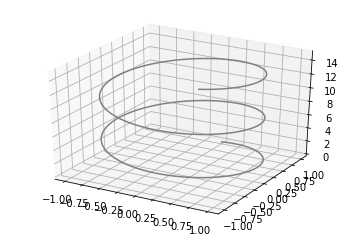

In [12]:
#one set of markers
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_row48977[Z_features].astype(float)
xdata = df_row48977[X_features].astype(float)
ydata = df_row48977[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 6's records plotted in 3D with Posture 3 (Stop sign)

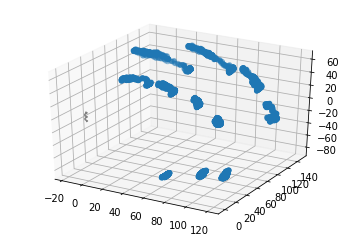

In [13]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user6[Z_features].astype(float)
xdata = df_user6[X_features].astype(float)
ydata = df_user6[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 14's records plotted in 3D with Class 1 (Fist Gesture)

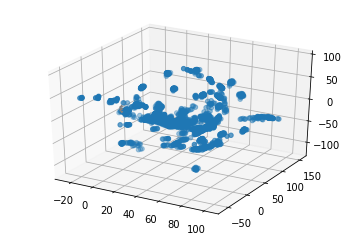

In [14]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user14[Z_features].astype(float)
xdata = df_user14[X_features].astype(float)
ydata = df_user14[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 8's records plotted in 3D with Class 3 (point with pointer finger Gesture)

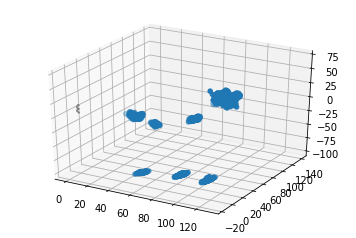

In [15]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user8[Z_features].astype(float)
xdata = df_user8[X_features].astype(float)
ydata = df_user8[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 5's records plotted in 3D with Class 5 (Grab Gesture)

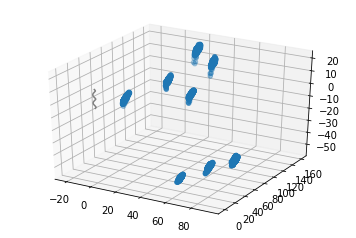

In [16]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user5[Z_features].astype(float)
xdata = df_user5[X_features].astype(float)
ydata = df_user5[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 5's records plotted in 3D in a Wireframe show Class 2 (Stop Gesture)

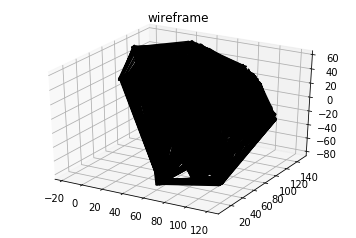

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(df_user6[X_features], df_user6[Y_features], df_user6[Z_features], color='black')
ax.set_title('wireframe');
